# Contents

* [Import libs](#libs)
* [Data Overview](#overview)

<a id='libs'></a>
## Import libs

In [7]:
from PIL import Image # image processing libs

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # show images and graphs

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from keras.optimizers import Adam
import keras_tuner as kt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

<a id='overview'></a>
# Data overview

<a id='data-loading'></a>
## Data loading

In [8]:
SUBMISSION_DATA_FILE_PATH = "ukraine-ml-bootcamp-2023/sample_submission.csv"
TRAIN_DATA_FILE_PATH = "ukraine-ml-bootcamp-2023/train.csv"

TRAIN_IMAGES_SRC_PATH = "ukraine-ml-bootcamp-2023/images/train_images/"
TEST_IMAGES_SRC_PATH = "ukraine-ml-bootcamp-2023/images/test_images/"

In [9]:
df = pd.read_csv(TRAIN_DATA_FILE_PATH)
image_size_df = df['image_id'].apply(lambda x: Image.open(TRAIN_IMAGES_SRC_PATH+x).size)
image_size_df.head()

0    (5410, 3607)
1    (2269, 1738)
2     (1023, 791)
3      (298, 300)
4      (736, 490)
Name: image_id, dtype: object

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360 entries, 0 to 2359
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  2360 non-null   object
 1   class_6   2360 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.0+ KB


<a id='classses-distribution'></a>
## Classes Distribution

<Axes: title={'center': 'Classes distribution'}, xlabel='class_6'>

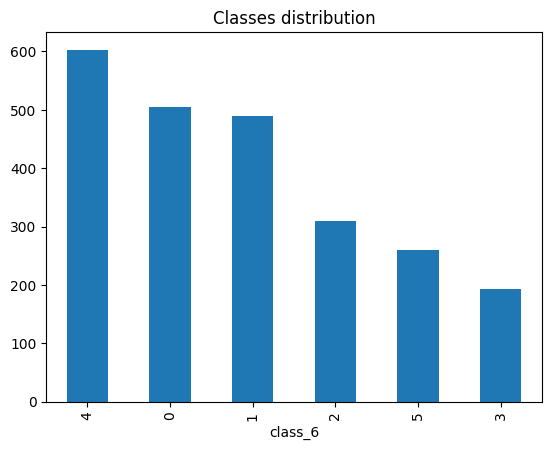

In [11]:
df['class_6'].value_counts().plot(kind='bar', title='Classes distribution')

<a id='preprocessing'></a>
# Preprocessing

In [12]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180
VALIDATION_SPLIT = 0.2

In [13]:
print(f"Train img name: {df.loc[0, 'image_id']} with label: {df.loc[0, 'class_6']}")

Train img name: 1daf45401342ac321c0aa5668f51d004.jpg with label: 5


<a id='val-split'></a>
## Validation split

In [14]:
df['class_6'] = df['class_6'].astype(str)
train_df, val_df = train_test_split(df, test_size=VALIDATION_SPLIT, stratify=df['class_6'])
print(f'Train data shape: {len(train_df)}')
print(f'Validation data shape: {len(val_df)}')

Train data shape: 1888
Validation data shape: 472


<a id='generators'></a>
## Data Generators

In [15]:
def train_val_generators(train_df, val_df, images_dir):
    # train data generator
    train_datagen = ImageDataGenerator(
        rescale=1./255,         # Rescale image values to [0,1]
        width_shift_range=0.1,  # Randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1, # Randomly shift images vertically (fraction of total height)
        shear_range=0.2,        # Randomly apply shear transformations
        zoom_range=0.2,         # Randomly zoom inside pictures
        fill_mode='nearest',    # The strategy used for filling in newly created pixels
    )
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=images_dir,
        x_col='image_id',
        y_col='class_6',
        batch_size=BATCH_SIZE,
        class_mode='categorical',  # Since class_6 is an integer label (0 to 5)
        target_size=(IMG_HEIGHT, IMG_WIDTH)  # Adjust the target size to the size of your input images
    )
    
    # validation data generator
    validation_datagen = ImageDataGenerator(rescale=1/255)
    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=images_dir,
        x_col='image_id',
        y_col='class_6',
        batch_size=BATCH_SIZE,
        class_mode='categorical',  # Since class_6 is an integer label (0 to 5)
        target_size=(IMG_HEIGHT, IMG_WIDTH)  # Adjust the target size to the size of your input images
    )

    return train_generator, validation_generator

In [16]:
train_generator, validation_generator = train_val_generators(train_df, val_df, TRAIN_IMAGES_SRC_PATH)

Found 1888 validated image filenames belonging to 6 classes.
Found 472 validated image filenames belonging to 6 classes.


<a id='model'></a>

# Model training

In [17]:
def plot_model_history(history):
    # Plot the chart for accuracy and loss on both training and validation
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [18]:
def build_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(6, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [19]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 64)      4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 172, 172, 64)      102464    
                                                                 
 max_pooling2d (MaxPooling2  (None, 86, 86, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 86, 86, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 84, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 82, 82, 128)       1

In [20]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=30)

Epoch 1/30
44/59 [=====================>........] - ETA: 1:30 - loss: 1.9784 - accuracy: 0.2173

KeyboardInterrupt: 